# Objcectron Tutorial: Parsing Annotation Data

This tutorial covers how to parse the annotation protobufs and visualize them on an image directly. 

The annotations are stored in [protocol buffer](https://developers.google.com/protocol-buffers) format. For more information, checkout [Protobuf Basics](https://developers.google.com/protocol-buffers/docs/pythontutorial#compiling-your-protocol-buffers). If you want to re-compile our protos to _pb2.py files, you'll need the [protobuf compiler](http://google.github.io/proto-lens/installing-protoc.html). The annotation protos are stored in objectron/schema folder.

In [11]:
annotation_file = '../example/book_batch-20_35.pbdata'
video_filename = '../example/book_batch-20_35_video.MOV'
# Along with the video.MOV file, there is a geometry.pbdata file that contains
# the geometry information of the scene (such as camera poses, point-clouds, and surfaces).
# There is a copy of this container within each annotation protobuf too.
geometry_filename = '../example/book_batch-20_35_geometry.pbdata'# a.k.a. AR metadata

In [12]:
import glob
import os
import subprocess
from absl import app
from absl import flags

#import box as Box
import cv2
import numpy as np

from google.protobuf import text_format
from IPython.core.display import display,HTML
import matplotlib.pyplot as plt

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# The annotations are stored in protocol buffer format. 
from objectron.schema import object_pb2 as object_protocol
from objectron.schema import annotation_data_pb2 as annotation_protocol
# The AR Metadata captured with each frame in the video
from objectron.schema import a_r_capture_metadata_pb2 as ar_metadata_protocol
from objectron.dataset import box as Box
from objectron.dataset import graphics

After loading the annotation proto from the file, we can iterate over each field
and convert them to numpy arrays or tf.tensors.

Notable fields are category, and keypoints. The keypoints contains the box's 9 keypoints.
The box is defined as follows:
```

              x                              x
      1 + + + + + + + + 5                 .-------
      +\                +\                |\
      + \ y             + \             z | \ y
      +  \              +  \              |  \
      +   3 + + + + + + + + 7
    z +   +             +   +
      +   +             +   +
      +   +     C=0     +   +
      +   +             +   +
      2 + + + + + + + + 6   +
       \  +              \  +
        \ +               \ +
         \+                \+
          4 + + + + + + + + 8
```
In the **world coordinate** system: $+y$ is up (aligned with gravity), $+z$ is toward the user, $+x$ follows right hand rule. The front face is defined as $+z$ axis on $xy$ plane.  The top face is defined as $+y$ axis on $xz$ plane.

Each annotation frame contains the keypoints in 3D in the **camera coordinates**, as well as their 2D-projection + depth in image coordinate. You can also get the box's 9-DoF parameters (rotation, translation, and scale) too.

In [13]:

def get_frame_annotation(sequence, frame_id):
  """Grab an annotated frame from the sequence."""
  data = sequence.frame_annotations[frame_id]
  object_id = 0
  object_keypoints_2d = []
  object_keypoints_3d = []
  object_rotations = []
  object_translations = []
  object_scale = []
  num_keypoints_per_object = []
  object_categories = []
  annotation_types = []
  # Get the camera for the current frame. We will use the camera to bring
  # the object from the world coordinate to the current camera coordinate.
  camera = np.array(data.camera.transform).reshape(4, 4)

  for obj in sequence.objects:
    rotation = np.array(obj.rotation).reshape(3, 3)
    translation = np.array(obj.translation)
    object_scale.append(np.array(obj.scale))
    transformation = np.identity(4)
    transformation[:3, :3] = rotation
    transformation[:3, 3] = translation
    obj_cam = np.matmul(camera, transformation)
    object_translations.append(obj_cam[:3, 3])
    object_rotations.append(obj_cam[:3, :3])
    object_categories.append(obj.category)
    annotation_types.append(obj.type)

  keypoint_size_list = []
  for annotations in data.annotations:
    num_keypoints = len(annotations.keypoints)
    keypoint_size_list.append(num_keypoints)
    for keypoint_id in range(num_keypoints):
      keypoint = annotations.keypoints[keypoint_id]
      object_keypoints_2d.append(
          (keypoint.point_2d.x, keypoint.point_2d.y, keypoint.point_2d.depth))
      object_keypoints_3d.append(
          (keypoint.point_3d.x, keypoint.point_3d.y, keypoint.point_3d.z))
    num_keypoints_per_object.append(num_keypoints)
    object_id += 1
  return (object_keypoints_2d, object_categories, keypoint_size_list,
          annotation_types)


A quick hack using ffmpeg to grab a single frame from a video file. This is very slow. We recommend using OpenCV if you want to grab multiple frames from the video file instead of this.

In [14]:
def grab_frame(video_file, frame_ids):
  """Grab an image frame from the video file."""
  frames = []
  capture = cv2.VideoCapture(video_file)
  height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
  capture.release()
  frame_size = width * height * 3

  for frame_id in frame_ids:
    frame_filter = r'select=\'eq(n\,{:d})\''.format(frame_id)
    command = [
        'ffmpeg', '-i', video_file, '-f', 'image2pipe', '-vf', frame_filter,
        '-pix_fmt', 'rgb24', '-vcodec', 'rawvideo', '-vsync', 'vfr', '-'
    ]
    pipe = subprocess.Popen(
        command, stdout=subprocess.PIPE, bufsize = 151 * frame_size)
    current_frame = np.fromstring(
        pipe.stdout.read(frame_size), dtype='uint8').reshape(width, height, 3)
    pipe.stdout.flush()

    frames.append(current_frame)
  return frames


Finally, grab a frame, load the corresponding annotation file and show the 3D bounding box on the image.

/home/yz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


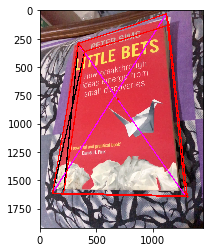

In [15]:
frame_id = 100
with open(annotation_file, 'rb') as pb:
    sequence = annotation_protocol.Sequence()
    sequence.ParseFromString(pb.read())
    frame = grab_frame(video_filename, [frame_id])
    annotation, cat, num_keypoints, types = get_frame_annotation(sequence, frame_id)
    image = graphics.draw_annotation_on_image(frame[0], annotation, num_keypoints)
    imgplot = plt.imshow(image)